# Generate Inputs for MCOE Calculations
One of the main things that we're building PUDL to do initially is enable the calculation of a marginal cost of electricity (MCOE) for the individual generators within plants. To do this, we need to bring together information from both FERC Form 1 and the EIA Form 923.

Given a target utility, we want to extract and summarize the following information, required to calculate the MCOE on a per plant and per generating unit basis:

* Generator capacities.
* Annual historical generation (in MWh) by each generator.
* Annual historical capacity factor for each generator.
* Annual historical heat rate (mmBTU/MWh) for each generator.
* Annual historical fuel costs per unit generation (\$/MWh) for each generator.
* Annual historical non-fuel production costs (\$/MWh) for each generator.
* Annual historical variable O&M costs (\$/MWh) for each generator.
* Annual historical fixed O&M costs by generator.

Some of these can be extracted directly from the tables we have, some will need to be calculated, and some will be our best estimates or inferrences.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%load_ext autoreload
%autoreload
pudl_engine = pudl.connect_db()

# Where does this data live?
PUDL DB tables that hold the information we're looking for:

### Cost Data:
* Cost of Fuel Delivered: `fuel_receipts_costs_eia923` and `fuel_ferc1`
* Non-Fuel Production Costs: `plants_steam_ferc1`
* Variable O&M Costs: `plants_steam_ferc1`
* Fixed O&M Costs: `plants_steam_ferc1`

### Generation Data:
* Annual Generation by Plant: `plants_steam_ferc1` and `generation_eia923`
* Monthly Generation by Unit: `generation_eia923`

### Fuel Use Data:
* Monthly Fuel Consumed by Unit: `generation_fuel_eia923`
* Annual Fuel Consumed by Plant: `fuel_ferc1`

### Capacity Data:
* Nameplate Capacity by Plant: `plants_steam_ferc1` and `plants_eia923`

In [2]:
# These IDs can be generated from each other based on the glue tables. But for now, let's assume that we know them.
PSCo_eia_id = 15466
PSCo_ferc_id = 145

# Extracting FERC Form 1 Fuel & Large Plant Data
We're going to pull information about a respondent, their large steam plants, and the fuel usage at those plants into a single dataframe for analysis.  Mostly what we are doing here is associating all the various IDs (FERC, EIA, PUDL) that we have, with the plant-by-plant data that we're interested in looking at from FERC.  This will allow us to select just the information that we're ultimately interested in, based on many different identifying criteria, and join it with information pulled from the EIA923 datasets.

In [3]:
pudl_tables = models.PUDLBase.metadata.tables
utilities_ferc = pudl_tables['utilities_ferc']
utilities_eia = pudl_tables['utilities_eia']
plants_ferc = pudl_tables['plants_ferc']
plants_eia = pudl_tables['plants_eia']
plants_pudl = pudl_tables['plants']
util_plant_assn = pudl_tables['util_plant_assn']
frc_eia923 = pudl_tables['fuel_receipts_costs_eia923']
gf_eia923 = pudl_tables['generation_fuel_eia923']
fuel_ferc1 = pudl_tables['fuel_ferc1']
steam_ferc1 = pudl_tables['plants_steam_ferc1']

In [4]:
def get_fuel_ferc1_df():
    fuel_ferc1_select = sa.sql.select([
        fuel_ferc1.c.report_year,
        utilities_ferc.c.respondent_id,
        utilities_eia.c.operator_id,
        utilities_ferc.c.util_id_pudl,
        utilities_ferc.c.respondent_name,
        plants_ferc.c.plant_id_pudl,
        plants_eia.c.plant_id,
        fuel_ferc1.c.plant_name,
        fuel_ferc1.c.fuel,
        fuel_ferc1.c.fuel_qty_burned,
        fuel_ferc1.c.fuel_avg_mmbtu_per_unit,
        fuel_ferc1.c.fuel_cost_per_unit_burned,
        fuel_ferc1.c.fuel_cost_per_unit_delivered,
        fuel_ferc1.c.fuel_cost_per_mmbtu,
        fuel_ferc1.c.fuel_cost_per_mwh,
        fuel_ferc1.c.fuel_mmbtu_per_mwh]).\
        where(sa.sql.and_(
            utilities_ferc.c.respondent_id == fuel_ferc1.c.respondent_id,
            plants_ferc.c.respondent_id == fuel_ferc1.c.respondent_id,
            plants_ferc.c.plant_name == fuel_ferc1.c.plant_name,
            utilities_eia.c.util_id_pudl == utilities_ferc.c.util_id_pudl,
            plants_eia.c.plant_id_pudl == plants_ferc.c.plant_id_pudl))

    return(pd.read_sql(fuel_ferc1_select, pudl_engine))

In [5]:
def get_steam_ferc1_df():
    steam_ferc1_select = sa.sql.select([
        steam_ferc1.c.report_year,
        utilities_ferc.c.respondent_id,
        utilities_eia.c.operator_id,
        utilities_ferc.c.util_id_pudl,
        utilities_ferc.c.respondent_name,
        plants_ferc.c.plant_id_pudl,
        plants_eia.c.plant_id,
        steam_ferc1.c.plant_name,
        steam_ferc1.c.total_capacity_mw,
        steam_ferc1.c.net_generation_mwh,
        steam_ferc1.c.expns_operations,
        steam_ferc1.c.expns_fuel,
        steam_ferc1.c.expns_coolants,
        steam_ferc1.c.expns_steam,
        steam_ferc1.c.expns_steam_other,
        steam_ferc1.c.expns_transfer,
        steam_ferc1.c.expns_electric,
        steam_ferc1.c.expns_misc_power,
        steam_ferc1.c.expns_rents,
        steam_ferc1.c.expns_allowances,
        steam_ferc1.c.expns_engineering,
        steam_ferc1.c.expns_structures,
        steam_ferc1.c.expns_boiler,
        steam_ferc1.c.expns_plants,
        steam_ferc1.c.expns_misc_steam,
        steam_ferc1.c.expns_production_total,
        steam_ferc1.c.expns_per_mwh]).\
        where(sa.sql.and_(
            utilities_ferc.c.respondent_id == steam_ferc1.c.respondent_id,
            plants_ferc.c.respondent_id == steam_ferc1.c.respondent_id,
            plants_ferc.c.plant_name == steam_ferc1.c.plant_name,
            utilities_eia.c.util_id_pudl == utilities_ferc.c.util_id_pudl,
            plants_eia.c.plant_id_pudl == plants_ferc.c.plant_id_pudl
        ))

    return(pd.read_sql(steam_ferc1_select, pudl_engine))

In [6]:
def get_gen_fuel_eia923_df():
    gf_eia923_select = sa.sql.select([
        utilities_eia.c.operator_id,
        utilities_eia.c.operator_name,
        plants_eia.c.plant_id_pudl,
        plants_eia.c.plant_name,
        gf_eia923.c.plant_id,
        gf_eia923.c.report_date,
        gf_eia923.c.aer_fuel_category,
        gf_eia923.c.fuel_consumed_total_mmbtu,
        gf_eia923.c.net_generation_mwh]).\
        where(sa.sql.and_(
            plants_eia.c.plant_id == gf_eia923.c.plant_id,
            util_plant_assn.c.plant_id == plants_eia.c.plant_id_pudl,
            util_plant_assn.c.utility_id == utilities_eia.c.util_id_pudl
        ))
        
    return(pd.read_sql(gf_eia923_select, pudl_engine))

In [85]:
def get_frc_eia923_df():
    frc_eia923_select = sa.sql.select([
        utilities_eia923.c.operator_id,
        utilities_eia923.c.operator_name,
        plants_eia923.c.plant_id_pudl,
        plants_eia923.c.plant_name,
        frc_eia923.c.plant_id,
        frc_eia923.c.report_date,
        frc_eia923.c.fuel_group,
        frc_eia923.c.average_heat_content,
        frc_eia923.c.fuel_quantity,
        frc_eia923.c.fuel_cost]).\
        where(sa.sql.and_(
            plants_eia923.c.plant_id == frc_eia923.c.plant_id,
            util_plant_assn.c.plant_id == plants_eia923.c.plant_id_pudl,
            util_plant_assn.c.utility_id == utilities_eia923.c.util_id_pudl
        ))
        
    return(pd.read_sql(frc_eia923_select, pudl_engine))

# Comparing FERC & EIA Data
How well can we correlate FERC & EIA Fuel data by plant?  The simplest case, which ought to give us a good indication of how well this can be done, will involve plants with a single generator, rather than conflating a bunch of sub-plants (different generators, more than one unit, etc.)  If the correlations between these simplest plants work well, then we can move on to more complex plants, using the variables which are shared between the two datasets to zip them together.  These shared variables potentially include the following:
- Total heat content of *each* fuel consumed, on an annual basis.
- Total cost of all heat consumed, on an annual basis.
- Total net electricity generated on an annual basis.

Doing this comparison will entail:
- Identifying those PUDL plant which contain only a single unit/boiler/generator/plant in both datasets.
- Calculating the above variables for each plant.
- Calculating the correlation between each of these variables for each plant, across the years 2009-2015.
- Creating a histogram of the per-plant correlations to see whether there is broad per-plant agreement.
- Calculating the correlation between each of these variables for all plant-year samples in the dataset.
- Creating a scatterplot showing the populations of all plant-year samples (should lie near the 1:1 line)

In [7]:
def get_simple_pudl_plants():
    """Find and return all PUDL plant_id values associated with a
    single FERC plant and a single EIA plant."""
    # We have three lists of plants: PUDL, FERC, and EIA.  Any PUDL plant ID
    # which only appears in all of those lists one time is a "simple" PUDL plant.
    
    ferc1_plant_ids = pd.read_sql('''SELECT plant_id_pudl FROM plants_ferc''', pudl_engine)
    ferc1_simple_plant_ids = ferc1_plant_ids.drop_duplicates('plant_id_pudl', keep=False)
    eia923_plant_ids = pd.read_sql('''SELECT plant_id_pudl FROM plants_eia''', pudl_engine)
    eia923_simple_plant_ids = eia923_plant_ids.drop_duplicates('plant_id_pudl', keep=False)
    pudl_simple_plant_ids = np.intersect1d(ferc1_simple_plant_ids['plant_id_pudl'],
                                           eia923_simple_plant_ids['plant_id_pudl'])
    return(pudl_simple_plant_ids)

In [8]:
def gen_fuel_by_pudl(pudl_plant_ids, fuels=['gas','oil','coal']):
    # Get all the EIA info from generation_fuel_eia923
    gf_df = get_gen_fuel_eia923_df()
    
    # Select only the records in these dataframes that pertain to our target IDs
    gf_df = gf_df[gf_df.plant_id_pudl.isin(pudl_plant_ids)]
    
    # Set the DF up for grouping
    gf_df['report_date'] = pd.to_datetime(gf_df['report_date'])
    gf_df.index = gf_df.report_date
    gf_df = gf_df.rename(columns={'aer_fuel_category':'fuel'})
    
    # Standardize the fuel codes (need to fix this in the DB!!!!)
    gf_df['fuel'] = gf_df.fuel.replace(to_replace='petroleum', value='oil')
    
    # If we're including all fuels, we're not grouping by fuel.
    if (fuels == 'all'):
        # Group EIA data by year, fuel, pudl_plant_id
        gf_gb = gf_df.groupby(by=[pd.TimeGrouper(freq='A'),'plant_id_pudl'])
    else:
        gf_gb = gf_df.groupby(by=[pd.TimeGrouper(freq='A'),'fuel','plant_id_pudl'])
    
    gf_totals = gf_gb[['fuel_consumed_total_mmbtu','net_generation_mwh']].sum()
    
    # Now we've got a DataFrame with total fuel consumed and total net generation!
    gf_totals_df = pd.DataFrame(gf_totals).reset_index()
    
    # Simplify date info for easy comparison with FERC.
    gf_totals_df['report_year'] = gf_totals_df['report_date'].dt.year
    
    return_cols = ['plant_id_pudl','report_year','fuel_consumed_total_mmbtu','net_generation_mwh']
    if (fuels != 'all'):
        gf_totals_df = gf_totals_df[gf_totals_df['fuel'].isin(fuels)]
        return_cols = return_cols + ['fuel',]
    
    # Simplify the DataFrame to return it for FERC comparison.
    gf_totals_df = gf_totals_df[return_cols]
    
    return(gf_totals_df)

In [124]:
def frc_by_pudl(pudl_plant_ids, fuels=['gas','oil','coal']):
    # Get all the EIA info from generation_fuel_eia923
    frc_df = get_frc_eia923_df()
    
    # Select only the records in these dataframes that pertain to our target IDs
    frc_df = frc_df[frc_df.plant_id_pudl.isin(pudl_plant_ids)]
    
    # Set the DF up for grouping
    frc_df['report_date'] = pd.to_datetime(frc_df['report_date'])
    frc_df.index = frc_df.report_date
    frc_df = frc_df.rename(columns={'fuel_group':'fuel'})
    
    # Standardize the fuel codes (need to fix this in the DB!!!!)
    frc_df['fuel'] = frc_df.fuel.replace(to_replace=['Petroleum','Natural Gas','Coal'],
                                         value=['oil','gas','coal'])
    frc_df['cost_eia923'] = frc_df['average_heat_content'] * frc_df['fuel_cost'] * frc_df['fuel_quantity'] / 100.0
    frc_cols = ['plant_id_pudl','report_date','fuel','cost_eia923']
    frc_df = frc_df[frc_cols]
    
    # If we're including all fuels, we're not grouping by fuel.
    if (fuels == 'all'):
        # Group EIA data by year, fuel, pudl_plant_id
        frc_gb = frc_df.groupby(by=[pd.TimeGrouper(freq='A'),'plant_id_pudl'])
    else:
        frc_gb = frc_df.groupby(by=[pd.TimeGrouper(freq='A'),'fuel','plant_id_pudl'])

    frc_totals = frc_gb['cost_eia923'].sum()
    # Now we've got a DataFrame with total fuel consumed and total net generation!
    frc_totals_df = pd.DataFrame(frc_totals).reset_index()

    # Simplify date info for easy comparison with FERC.
    frc_totals_df['report_year'] = frc_totals_df['report_date'].dt.year
    
    return_cols = ['plant_id_pudl','report_year','cost_eia923']
    if (fuels != 'all'):
        frc_totals_df = frc_totals_df[frc_totals_df['fuel'].isin(fuels)]
        return_cols = return_cols + ['fuel',]

    # Simplify the DataFrame to return it for FERC comparison.
    frc_totals_df = frc_totals_df[return_cols]
    frc_totals_df = frc_totals_df.dropna()
    
    return(frc_totals_df)

In [125]:
frc_totals_df = frc_by_pudl(simple_plants, fuels=fuels)

In [126]:
frc_totals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 5 to 3008
Data columns (total 4 columns):
plant_id_pudl    2665 non-null int64
report_year      2665 non-null int64
cost_eia923      2665 non-null float64
fuel             2665 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 104.1+ KB


In [76]:
def fuel_ferc1_by_pudl(pudl_plant_ids, fuels=['gas','oil','coal']):
    
    fuel_df = get_fuel_ferc1_df()

    # Calculate the total fuel heat content for the plant by fuel
    fuel_df['fuel_consumed_total_mmbtu'] = fuel_df['fuel_qty_burned'] * fuel_df['fuel_avg_mmbtu_per_unit']
    fuel_df = fuel_df[fuel_df.plant_id_pudl.isin(pudl_plant_ids)]

    # We have two different ways of assessing the total cost of fuel
    # given cost per unit delivered and cost per mmbtu. They *should* be the same,
    # but we know they aren't always. Calculate both so we can compare both.
    fuel_df['fuel_consumed_total_cost_mmbtu'] = fuel_df['fuel_cost_per_mmbtu'] * fuel_df['fuel_consumed_total_mmbtu']
    fuel_df['fuel_consumed_total_cost_unit'] = fuel_df['fuel_qty_burned'] * fuel_df['fuel_cost_per_unit_burned']

    # List of the columns we actually want to hold on to for comparing EIA & FERC.
    fuel_cols = ['plant_id_pudl', 'report_year', 'fuel',
                 'fuel_consumed_total_mmbtu',
                 'fuel_consumed_total_cost_mmbtu',
                 'fuel_consumed_total_cost_unit']

    fuel_df = fuel_df[fuel_cols]

    if (fuels != 'all'):
        # Limit to records that pertain to our fuels of interest.
        fuel_df = fuel_df[fuel_df['fuel'].isin(fuels)]
    
    return(fuel_df)

In [10]:
def steam_ferc1_by_pudl(pudl_plant_ids):
    
    steam_df = get_steam_ferc1_df()

    steam_df = steam_df[steam_df.plant_id_pudl.isin(pudl_plant_ids)]

    # List of the columns we actually want to hold on to for comparing EIA & FERC.
    steam_cols = ['plant_id_pudl', 'report_year', 'net_generation_mwh']

    steam_df = steam_df[steam_cols]

    return(steam_df)

In [11]:
def pudl_plant_fuel_consumed(pudl_plant_ids, fuels=['gas','oil','coal']):
    """Calculate total annual fuel consumption for a list of PUDL plants.
    For each pudl_plant_id provided, calculate the total heat content of fuel
    consumed, for each specified type of fuel.
    Do separate tallies based on the EIA923 and FERC1 datasets.
    
    DataFrame Fields:
    - pudl_plant_id
    - year
    - fuel
    - mmbtu_eia923
    - mmbtu_ferc1
    """
    # This gives us a DataFrame with annual total fuel consumed (and net generation)
    # with report_year, PUDL plant ID and fuel information.
    gf_totals_df = gen_fuel_by_pudl(pudl_plant_ids, fuels=fuels)
    gf_totals_df = gf_totals_df.drop('net_generation_mwh', axis=1)
    gf_totals_df = gf_totals_df.rename(columns={'fuel_consumed_total_mmbtu':'mmbtu_eia923'})
    
    # Now we need to grab the analogous information from FERC Form 1:
    fuel_totals_df = fuel_ferc1_by_pudl(pudl_plant_ids, fuels=fuels)
    fuel_totals_df = fuel_totals_df.drop(['fuel_consumed_total_cost_mmbtu','fuel_consumed_total_cost_unit'], axis=1)
    fuel_totals_df = fuel_totals_df.rename(columns={'fuel_consumed_total_mmbtu':'mmbtu_ferc1'})

    return(pd.merge(gf_totals_df, fuel_totals_df, on=['plant_id_pudl','report_year','fuel']))

In [29]:
def pudl_plant_net_generation(pudl_plant_ids):
    """Calculate total annual net generation for a list of PUDL plants.
    
    DataFrame Fields:
    - pudl_plant_id
    - year
    - mwh_eia923
    - mwh_ferc1
    """
    # This gives us a DataFrame with annual total fuel consumed (and net generation)
    # with report_year, PUDL plant ID and fuel information.
    gf_totals_df = gen_fuel_by_pudl(pudl_plant_ids, fuels='all')
    gf_totals_df = gf_totals_df.drop('fuel_consumed_total_mmbtu', axis=1)
    gf_totals_df = gf_totals_df.rename(columns={'net_generation_mwh':'mwh_eia923'})
    
    steam_totals_df = steam_ferc1_by_pudl(pudl_plant_ids)
    steam_totals_df = steam_totals_df.rename(columns={'net_generation_mwh':'mwh_ferc1'})

    return(pd.merge(gf_totals_df, steam_totals_df, on=['plant_id_pudl','report_year']))

In [127]:
def pudl_plant_fuel_cost(pudl_plant_ids, fuels=['gas','oil','coal']):
    """Calculate total annual fuel costs, on a per fuel and per-PUDL plant basis
    
    DataFrame Fields:
    - pudl_plant_id
    - year
    - fuel
    - cost_eia923
    - cost_mmbtu_ferc1
    - cost_unit_ferc1
    - cost_steam_ferc1 (do we really need/want this one?)
    """
    # EIA 923 fuel cost data comes from the fuel_receipts_costs table.
    # This data can be broken out by fuel type.
    frc_totals_df = frc_by_pudl(pudl_plant_ids, fuels=fuels)
    
    # There are several ways to get fuel costs from FERC Form 1
    # per-unit and per-mmbtu fuel costs are reported in f1_fuel,
    # along with the total units and total heat content consumed.
    fuel_totals_df = fuel_ferc1_by_pudl(pudl_plant_ids, fuels=fuels)
    fuel_totals_df = fuel_totals_df.drop('fuel_consumed_total_mmbtu', axis=1)
    fuel_totals_df = fuel_totals_df.rename(columns={'fuel_consumed_total_cost_mmbtu':'cost_mmbtu_ferc1',
                                                    'fuel_consumed_total_cost_unit':'cost_unit_ferc1'})
    
    # Total fuel expenses are reported in the f1_steam table.
    # It's not clear that this adds information to the analysis though...
    #steam_totals_df = steam_ferc1_by_pudl
    return(pd.merge(frc_totals_df, fuel_totals_df, on=['plant_id_pudl','fuel','report_year']))

In [131]:
simple_plants = get_simple_pudl_plants()
fuels = ['gas','oil','coal']

fuel_eia923_ferc1 = pudl_plant_fuel_consumed(simple_plants, fuels=fuels)
netgen_eia923_ferc1 = pudl_plant_net_generation(simple_plants)
cost_eia923_ferc1 = pudl_plant_fuel_cost(simple_plants, fuels=fuels)

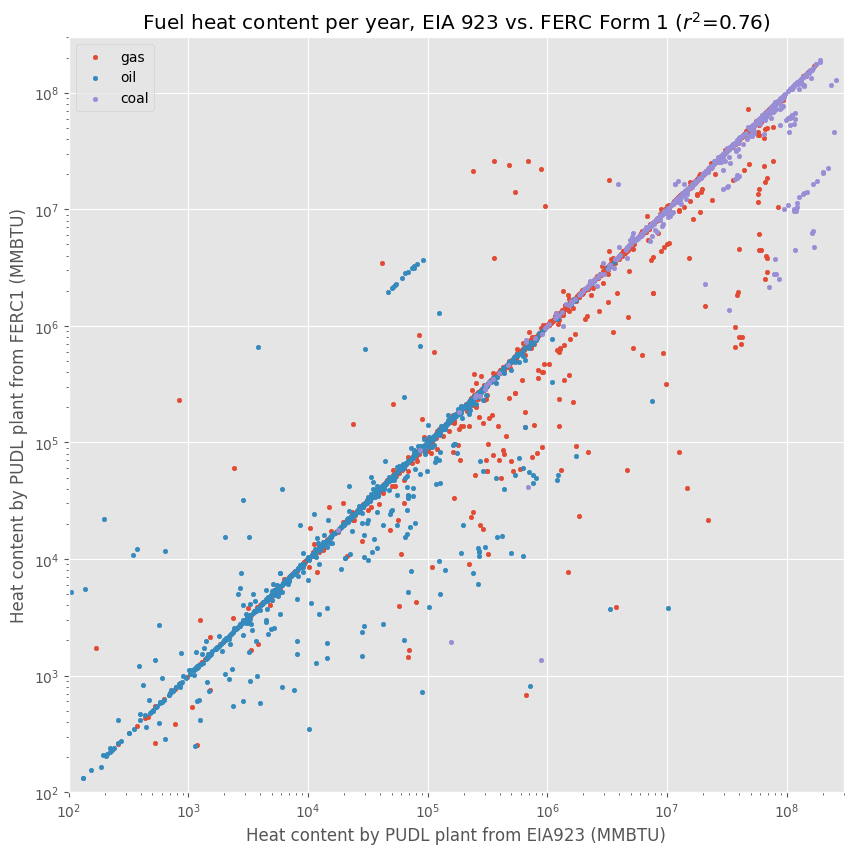

In [53]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(100)
ax.loglog()
plt.ylim(100,3e8)
plt.xlim(100,3e8)
plt.grid(b=True)
for fuel in fuels:
    ax.scatter(fuel_eia923_ferc1[(fuel_eia923_ferc1.fuel==fuel)]['mmbtu_eia923'],
               fuel_eia923_ferc1[(fuel_eia923_ferc1.fuel==fuel)]['mmbtu_ferc1'],
               label=fuel, s=10)
ax.legend(loc='upper left')
R2 = np.corrcoef(fuel_eia923_ferc1.mmbtu_eia923, fuel_eia923_ferc1.mmbtu_ferc1)[0,1]**2
plt.title("Fuel heat content per year, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Heat content by PUDL plant from EIA923 (MMBTU)")
plt.ylabel("Heat content by PUDL plant from FERC1 (MMBTU)")
plt.show();

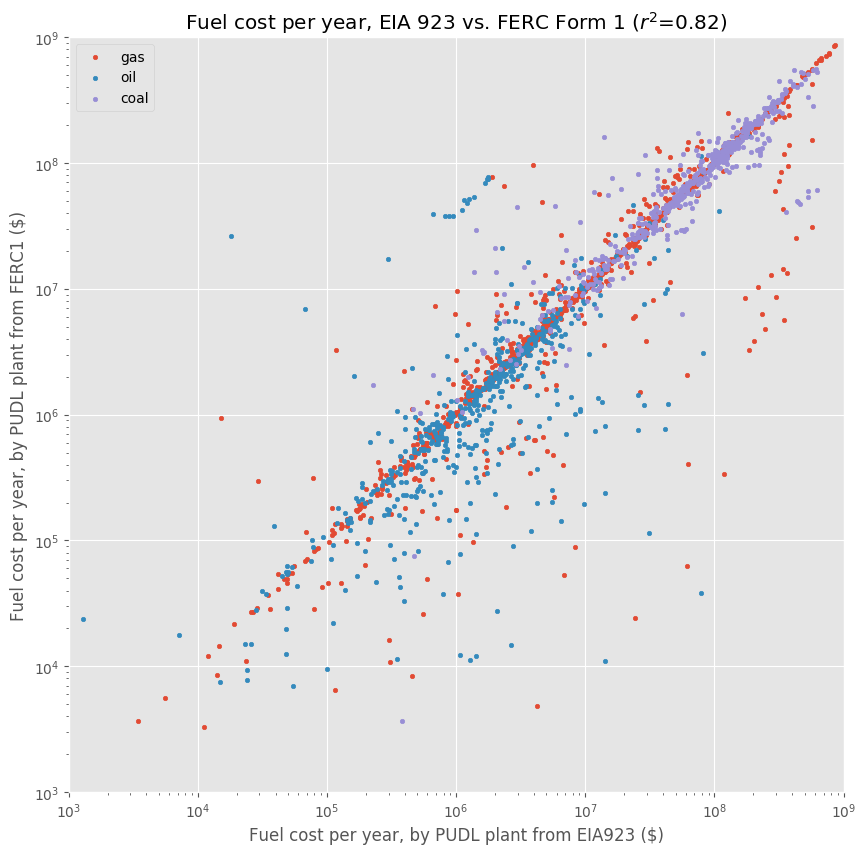

In [138]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(100)
ax.loglog()
plt.ylim(1e3,1e9)
plt.xlim(1e3,1e9)
plt.grid(b=True)
for fuel in fuels:
    ax.scatter(cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_eia923'],
               cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_mmbtu_ferc1'],
               label=fuel, s=10)
ax.legend(loc='upper left')
R2 = np.corrcoef(cost_eia923_ferc1.cost_eia923, cost_eia923_ferc1.cost_mmbtu_ferc1)[0,1]**2
plt.title("Fuel cost per year, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Fuel cost per year, by PUDL plant from EIA923 ($)")
plt.ylabel("Fuel cost per year, by PUDL plant from FERC1 ($)")
plt.show();

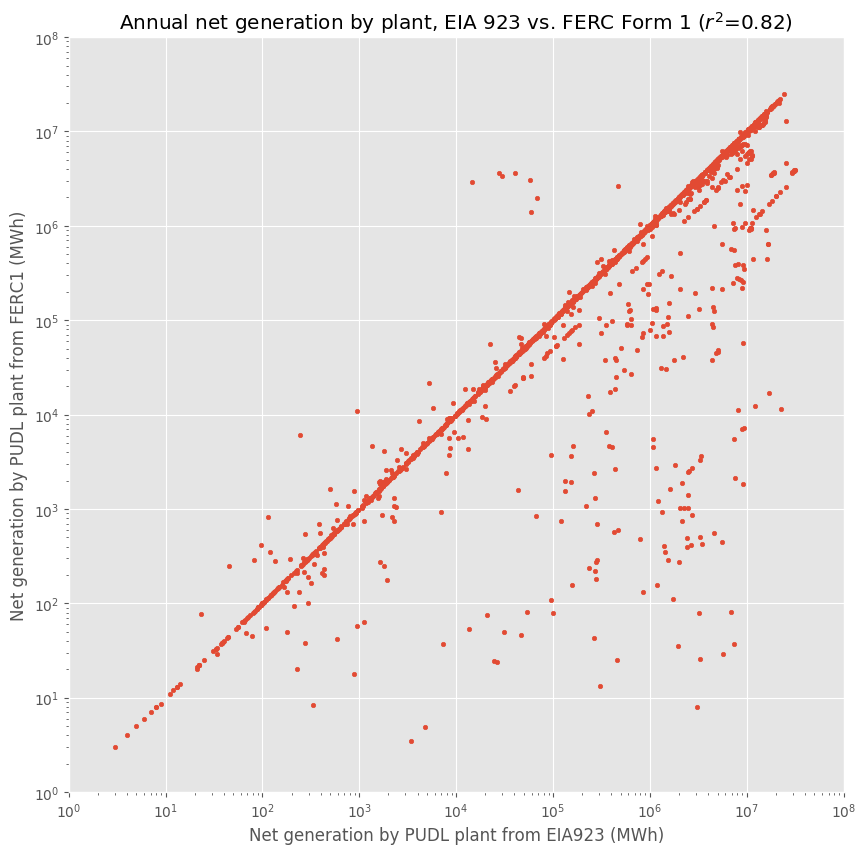

In [135]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(100)
ax.loglog()
plt.ylim(1,1e8)
plt.xlim(1,1e8)
plt.grid(b=True)
R2 = np.corrcoef(cost_eia923_ferc1.cost_eia923, cost_eia923_ferc1.cost_mmbtu_ferc1)[0,1]**2
ax.scatter(netgen_eia923_ferc1['mwh_eia923'],
           netgen_eia923_ferc1['mwh_ferc1'],
           s=10)
plt.title("Annual net generation by plant, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Net generation by PUDL plant from EIA923 (MWh)")
plt.ylabel("Net generation by PUDL plant from FERC1 (MWh)")
plt.show();

In [ ]:
fuel_df['total_mmbtu'] = fuel_df['fuel_qty_burned']*fuel_df['fuel_avg_mmbtu_per_unit']
fuel_df['total_fuel_cost_mmbtu'] = fuel_df['fuel_cost_per_mmbtu']*fuel_df['total_mmbtu']
fuel_df['total_fuel_cost_units'] = fuel_df['fuel_cost_per_unit_burned']*fuel_df['fuel_qty_burned']
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(100)
ax.loglog()
plt.ylim(10,1e9)
plt.xlim(10,1e9)
plt.grid()
target=145 # PSCo
#target=134 # PacifiCorp
#target=133 # PG&E
for fuel in ['oil','gas','coal']:
#    ax.scatter(fuel_df[(fuel_df.fuel==fuel) & (fuel_df.respondent_id==target)]['total_fuel_cost_mmbtu'],
#               fuel_df[(fuel_df.fuel==fuel) & (fuel_df.respondent_id==target)]['total_fuel_cost_units'],
#               label=fuel, s=10)
    ax.scatter(fuel_df[(fuel_df.fuel==fuel)]['total_fuel_cost_mmbtu'],
               fuel_df[(fuel_df.fuel==fuel)]['total_fuel_cost_units'],
               label=fuel, s=10)
ax.legend(loc='lower right')
plt.ylabel("Total fuel cost based on units burned (tons, barrels, mcf).")
plt.xlabel("Total fuel cost based on energy content (mmBTU).")

In [ ]:
# These are useful fields shared by fuel and plant dataframes:
ferc_merge_fields = ['report_year',
                     'respondent_id',
                     'operator_id',
                     'util_id_pudl',
                     'respondent_name',
                     'plant_id_pudl',
                     'plant_id',
                     'plant_name']

index_cols = ['util_id_pudl','plant_id_pudl','report_year']

ferc_merge = fuel_df[ferc_merge_fields].copy()
ferc_merge = ferc_merge.drop_duplicates(subset=index_cols)

fuel_by_plant_year = fuel_df.groupby(index_cols)

# Fields we want to pull in from the fuel dataframe, by plant_id_pudl
fuel_merge_fields = ['total_mmbtu',
                     'total_fuel_cost_units',
                     'total_fuel_cost_mmbtu']

for field in fuel_merge_fields:
    ferc_merge = ferc_merge.merge(pd.DataFrame(fuel_by_plant_year[field].sum()),
                                  left_on=index_cols,
                                  right_index=True)

# Fields we're ultimately trying to get from the steam dataframe:
steam_merge_fields = ['total_capacity_mw',
                      'net_generation_mwh',
                      'expns_fuel',
                      'expns_nonfuel_production',
                      'expns_nonproduction']

# But first we need to calculate the non-fuel production and non-production expenses:
expns_corr = analysis.ferc1_expns_corr(pudl_engine, capacity_factor=0.6)

steam_bad_cols = ['expns_fuel', 'expns_per_mwh','expns_production_total']
# Remove the expns_* columns that we don't want to aggregate
for key in steam_bad_cols:
    x = expns_corr.pop(key, None)
    
# For now using correlation with net_generation > 0.5 as indication of "production" vs. non-produciton
expns_nonfuel_production = [k for k in expns_corr.keys() if expns_corr[k] >= 0.5]
expns_nonproduction = [k for k in expns_corr.keys() if expns_corr[k] < 0.5]

steam_df['expns_nonfuel_production'] = steam_df[expns_nonfuel_production].copy().sum(axis=1)
steam_df['expns_nonproduction'] = steam_df[expns_nonproduction].copy().sum(axis=1)
    
steam_by_plant_year = steam_df.groupby(index_cols)

for field in steam_merge_fields:
    ferc_merge = ferc_merge.merge(pd.DataFrame(steam_by_plant_year[field].sum()),
                                  left_on=index_cols,
                                  right_index=True)

In [ ]:
ferc_merge['expns_fuel_per_mwh'] = ferc_merge['expns_fuel'] / ferc_merge['net_generation_mwh']
ferc_merge['expns_nonfuel_production_per_mwh'] = ferc_merge['expns_nonfuel_production'] / ferc_merge['net_generation_mwh']
ferc_merge['expns_nonproduction_per_mwh'] = ferc_merge['expns_nonproduction'] / ferc_merge['net_generation_mwh']
ferc_merge['expns_nonproduction_per_mw'] = ferc_merge['expns_nonproduction'] / ferc_merge['total_capacity_mw']
ferc_merge['mmbtu_per_mwh'] = ferc_merge['total_mmbtu'] / ferc_merge['net_generation_mwh']
ferc_merge['capacity_factor'] = ferc_merge['net_generation_mwh'] / (8760 * ferc_merge['total_capacity_mw'])

In [ ]:
fuel_df[fuel_df['plant_id_pudl']==627]

In [ ]:
frc_eia923_select = sa.sql.select([
    utilities_eia.c.util_id_pudl,
    utilities_eia.c.operator_id,
    utilities_eia.c.operator_name,
    plants_eia.c.plant_id_pudl,
    plants_eia.c.plant_id,
    plants_eia.c.plant_name,
    frc_eia923.c.report_date,
    frc_eia923.c.energy_source,
    frc_eia923.c.fuel_group,
    frc_eia923.c.fuel_quantity,
    frc_eia923.c.average_heat_content,
    frc_eia923.c.fuel_cost
    ]).\
    where(sa.sql.and_(
        plants_eia.c.plant_id == frc_eia923.c.plant_id,
        util_plant_assn.c.plant_id == plants_eia.c.plant_id_pudl,
        util_plant_assn.c.utility_id == utilities_eia.c.util_id_pudl
    ))
    
frc_df = pd.read_sql(frc_eia923_select, pudl_engine)

#frc_df = pd.read_sql('''SELECT * FROM fuel_receipts_costs_eia923''', pudl_engine)
#frc_df[frc_df['plant_id']==477]

In [ ]:
gf_df = pd.read_sql('''SELECT * FROM generation_fuel_eia923''', pudl_engine)

In [ ]:
frc_df[frc_df['plant_name'].str.contains('almont')]

In [ ]:
craig_frc = frc_df[frc_df['plant_name']=='Craig (CO)']
len(craig_frc[craig_frc['operator_id']==15466])

In [ ]:
plants_eia_df = pd.read_sql('''SELECT * FROM plants_eia''', pudl_engine)

In [ ]:
fuel_df[fuel_df['plant_name'].str.contains('almont')][['report_year','plant_name','fuel','total_mmbtu']]

In [ ]:
plants_eia_df[plants_eia_df['plant_name'].str.contains('almont')]
frc_df[frc_df['plant_id'].isin([477,55207])][['plant_id','report_date','fuel_group','fuel_quantity','average_heat_content']]

In [ ]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(100)
ax.loglog()
plt.ylim(1,1e10)
plt.xlim(1,1e10)
plt.grid()
target=145 # PSCo
#target=134 # PacifiCorp
#target=133 # PG&E
#    ax.scatter(fuel_df[(fuel_df.fuel==fuel) & (fuel_df.respondent_id==target)]['total_fuel_cost_mmbtu'],
#               fuel_df[(fuel_df.fuel==fuel) & (fuel_df.respondent_id==target)]['total_fuel_cost_units'],
#               label=fuel, s=10)
ax.scatter(ferc_merge['total_fuel_cost_mmbtu'],
           ferc_merge['total_fuel_cost_units'],
           s=10)
ax.scatter(ferc_merge['expns_fuel'],
           ferc_merge['total_fuel_cost_units'],
           s=10)
ax.scatter(ferc_merge['total_fuel_cost_mmbtu'],
           ferc_merge['expns_fuel'],
           s=10)
plt.ylabel("Total fuel cost based on units burned (tons, barrels, mcf).")
plt.xlabel("Total fuel cost based on energy content (mmBTU).")

In [ ]:
cap_fac = ferc_merge[ferc_merge['capacity_factor'].apply(np.isfinite)]['capacity_factor']

In [ ]:
fig = plt.hist(cap_fac, bins=100, range=(0,1))

In [ ]:
fig = plt.hist(ferc_merge['mmbtu_per_mwh'], bins=100, range=(0,100))

In [ ]:
fig = plt.hist(ferc_merge['expns_fuel_per_mwh'], bins=100, range=(0,100))

In [ ]:
ferc_merge['expns_total'] = ferc_merge['expns_fuel'] + \
                            ferc_merge['expns_nonfuel_production'] + \
                            ferc_merge['expns_nonproduction']

In [ ]:
ferc_merge['expns_total_per_mwh'] = ferc_merge['expns_total'] / ferc_merge['net_generation_mwh']

In [ ]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.set_dpi(100)
plt.grid()
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Total Fuel, Production, & Non-production Costs ($/MWh)")
x = ax.hist(ferc_merge['expns_total_per_mwh'], bins=100, range=(0,200))

In [ ]:
sa.__version__